# **House Sales Price Study**

## Objectives

* Answer business requirement 1:
  * The client is interested to understand the most relevant house variables correlate against the sale price.

## Inputs

* outputs/datasets/collection/house_prices_after_inspection.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build the Streamlit App

## Additional Comments

* Data derives from Kaggle but has been provided by CI 


---

# Change working directory to the parent folder

Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-heritage-housing-issues/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-heritage-housing-issues'

# Load the Data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_after_inspection.csv")
#df.head()
df.tail()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125
1459,1256,0.0,3.0,No,830,BLQ,136,0.0,276,Fin,...,75.0,0.0,68,6,5,1256,736.0,1965,1965,147500


In [42]:
df_to_clean = df.copy()
df_to_clean.tail()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125
1459,1256,0.0,3.0,No,830,BLQ,136,0.0,276,Fin,...,75.0,0.0,68,6,5,1256,736.0,1965,1965,147500


# Create a profile report for quick Exploratory Data Analysis (EDA)

In [43]:
from ydata_profiling import ProfileReport
profile_report= ProfileReport(df=df_to_clean, minimal=True)
#profile_report
#profile_report.to_notebook_iframe()

## EDA Observations

* This dataset hast a predominance for numerical variables.
* Only 4 variables are categorical: BsmtExposure, BsmtFinType1, GarageFinish, KitchenQual
* The 4 categorical variables are imbalanced.
* Several variables have missing values and zeros.
* Most numerical variables seem to be not normally distributed. 

# Handle Missing Values (NaN)

In [44]:
df_to_clean.isnull().sum().to_frame(name="Is Null")

,Is Null
1stFlrSF,0
2ndFlrSF,86
BedroomAbvGr,99
BsmtExposure,38
BsmtFinSF1,0
BsmtFinType1,145
BsmtUnfSF,0
EnclosedPorch,1324
GarageArea,0
GarageFinish,235


In [45]:
categorical_variables = df_to_clean.select_dtypes(include='object').columns.to_list()
categorical_variables

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

In [46]:
for col in df_to_clean.select_dtypes(include="object"):
    print(df_to_clean[col].value_counts())

BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64
BsmtFinType1
Unf    396
GLQ    385
ALQ    202
BLQ    136
Rec    126
LwQ     70
Name: count, dtype: int64
GarageFinish
Unf    546
RFn    366
Fin    313
Name: count, dtype: int64
KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64


In [47]:
from feature_engine.imputation import CategoricalImputer
categorical_imputer= CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=categorical_variables)
df_categ_imputed =categorical_imputer.fit_transform(df_to_clean)

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


In [48]:
df_categ_imputed[categorical_variables].isnull().sum().to_frame(name="Is Null")

,Is Null
BsmtExposure,0
BsmtFinType1,0
GarageFinish,0
KitchenQual,0


In [49]:
import pingouin as pg
pg.normality(data=df_categ_imputed, alpha = 0.05) # check normality: They are all not normally distributed


,W,pval,normal
1stFlrSF,0.926946,4.513223e-26,False
2ndFlrSF,0.766299,2.292182e-40,False
BedroomAbvGr,0.849687,4.357370e-34,False
BsmtFinSF1,0.847960,2.813854e-35,False
BsmtUnfSF,0.930422,1.639911e-25,False
EnclosedPorch,0.431425,9.674916e-21,False
GarageArea,0.975327,4.016963e-15,False
GarageYrBlt,0.920943,2.816783e-26,False
GrLivArea,0.927983,6.597610e-26,False
LotArea,0.351059,7.933654e-58,False


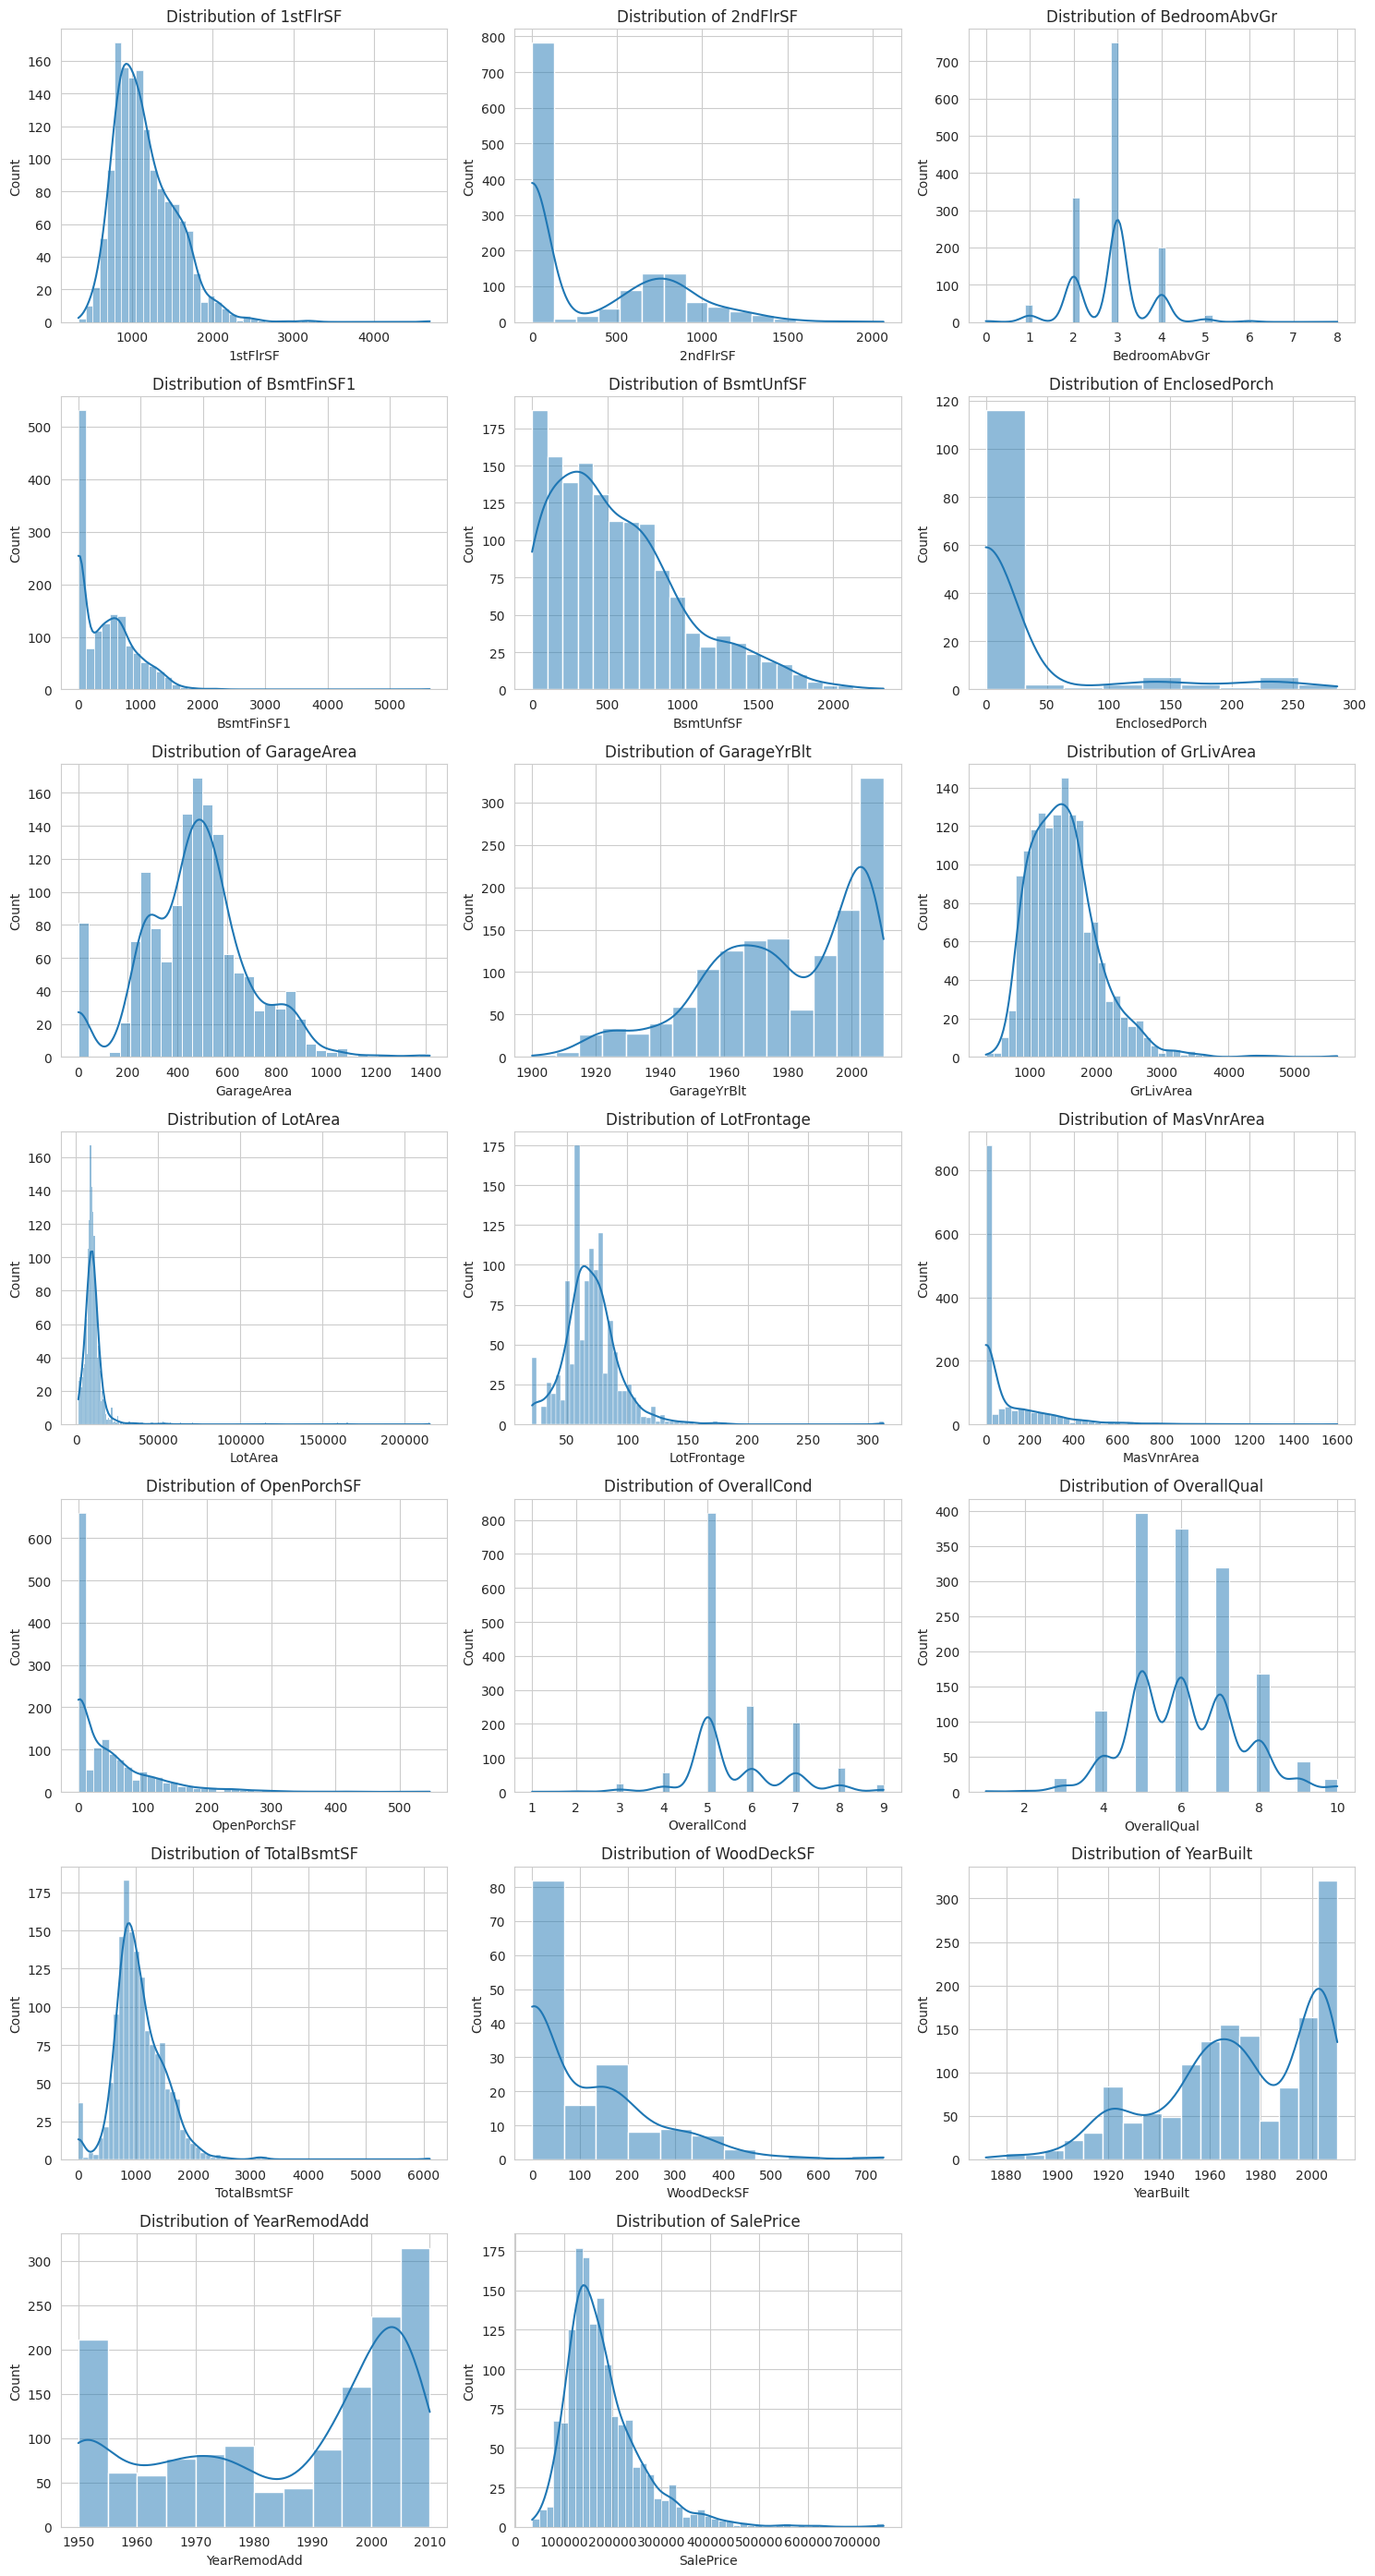

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
# for col in df.select_dtypes(include="number").columns:
  # sns.histplot(data=df, x=col, kde=True)
  # plt.show()
  # print('\n')

numerical_variables = df_categ_imputed.select_dtypes(include="number").columns

n_cols = 3
n_rows = (len(numerical_variables) + n_cols - 1) // n_cols

# Create the figure and subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

# Flatten the axes array if there's more than one row/column
axes = axes.flatten()

# Iterate through columns and plot on respective axes
for i, col in enumerate(numerical_variables):
    sns.histplot(data=df_categ_imputed, x=col, kde=True, ax=axes[i]) 
    axes[i].set_title(f'Distribution of {col}')

# Remove unused subplots
for j in range(len(numerical_variables), len(axes)):
    fig.delaxes(axes[j])

# Prevent titles/labels from overlapping
plt.tight_layout()

# Display all plots
plt.show()


In [57]:
numerical_variables = df_categ_imputed.select_dtypes(include="number").columns.to_list()

from feature_engine.imputation import MeanMedianImputer
numerical_imputer = MeanMedianImputer(imputation_method='median',
                            variables= numerical_variables)

df_categ_and_numb_imputed = numerical_imputer.fit_transform(df_categ_imputed)


In [58]:
df_categ_and_numb_imputed.isnull().sum().to_frame(name="Is Null")

,Is Null
1stFlrSF,0
2ndFlrSF,0
BedroomAbvGr,0
BsmtExposure,0
BsmtFinSF1,0
BsmtFinType1,0
BsmtUnfSF,0
EnclosedPorch,0
GarageArea,0
GarageFinish,0


# Correlation Study: Pearson and Spearman

**Goal:** identify how the target (SalesPrice) correlate to the variables, and retrieve the top 5 correlation variables for SalesPrice.

* Step 1: Handle M

* Step 1: Since Spearman and Peason need numeric variables: transform categorical variables to numerical variables using one hot encoding.

In [60]:
from feature_engine.encoding import OneHotEncoder
one_hot_encoder = OneHotEncoder(variables=df_categ_and_numb_imputed.select_dtypes(include='object').columns.to_list(), drop_last=False)
#one_hot_encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = one_hot_encoder.fit_transform(df_categ_and_numb_imputed)
df_ohe.tail()


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageYrBlt,GrLivArea,LotArea,...,BsmtFinType1_BLQ,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Missing,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
1455,953,694.0,3.0,0,953,0.0,460,1999.0,1647,7917,...,0,0,1,0,0,0,0,1,0,0
1456,2073,0.0,3.0,790,589,0.0,500,1978.0,2073,13175,...,0,0,0,1,0,0,0,1,0,0
1457,1188,1152.0,4.0,275,877,0.0,252,1941.0,2340,9042,...,0,0,1,0,0,0,1,0,0,0
1458,1078,0.0,2.0,49,0,112.0,240,1950.0,1078,9717,...,0,0,0,1,0,0,1,0,0,0
1459,1256,0.0,3.0,830,136,0.0,276,1965.0,1256,9937,...,1,0,0,0,0,1,0,1,0,0


In [61]:
categorical_variables = df_ohe.select_dtypes(include='object').columns.to_list()
categorical_variables

[]

In [68]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10).to_frame(name="Correlation Coefficient")
corr_pearson

,Correlation Coefficient
OverallQual,0.790982
GrLivArea,0.708624
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
YearBuilt,0.522897
KitchenQual_TA,-0.519298
YearRemodAdd,0.507101
KitchenQual_Ex,0.504094
MasVnrArea,0.472614


---

In [69]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10).to_frame(name="Correlation Coefficient")
corr_spearman

,Correlation Coefficient
OverallQual,0.809829
GrLivArea,0.731310
YearBuilt,0.652682
GarageArea,0.649379
TotalBsmtSF,0.602725
KitchenQual_TA,-0.581803
1stFlrSF,0.575408
YearRemodAdd,0.571159
GarageYrBlt,0.563256
KitchenQual_Gd,0.478583


# Load and Inspect Kaggle data

### Read CSV files

In [ ]:
import pandas as pd
df_house_prices = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv") 
df_house_prices.head()
# print(df.shape)


In [ ]:
df_inherited_houses = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv") 
df_inherited_houses.head()
# print(df.shape)

### Read TXT files

In [ ]:
df_house_metadata = pd.read_csv(f"inputs/datasets/raw/house-metadata.txt", header=None) 
df_house_metadata.head()
# print(df_house_metadata.shape)

### DataFrames Summary

In [ ]:
df_house_prices.info()

In [ ]:
df_inherited_houses.info()

In [ ]:
df_house_metadata.info()

### Check for duplicates 
* There are no duplicates in the data, there is also no unique indentifier such as "HouseID" to drop.

In [ ]:
df_house_prices.duplicated().sum()

### Confirm Target data type
* The target is already a numeric variable.

In [ ]:
df_house_prices['SalePrice'].dtype

### Notes
* The variables GarageYrBlt, YearBuilt and YearRemodAdd are numeric. 
* While they could be converted to datetime data type, their current numerical format facilitates their use in Pearson and Spearman correlation analyses and as direct inputs for the regression model.

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

### Create outputs directory

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/collection')
except Exception as e:
  print(e)


### Save the data under as csv

In [ ]:
df_house_prices.to_csv(f"outputs/datasets/collection/house_prices_after_inspection.csv", index=False)